In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import cbc, numpy as np, scipy as sp, matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
waist = 4e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 2
detNx, detNy = 128, 128
pix_size = 55e-3
det_dist = 30

# Gaussian beam

In [3]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

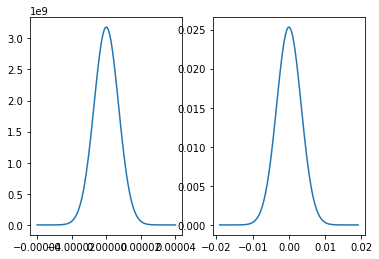

In [42]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us)
ax2.plot(kxs, ufs)
plt.show()

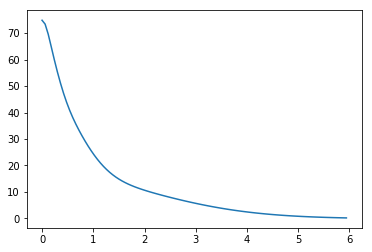

In [32]:
%matplotlib inline
ss = np.linspace(0, 6.0, 100, endpoint=False)
asfs = cbc.asf_vals(ss, cbc.asf_coeffs())
plt.plot(ss, asfs)
plt.show()

In [33]:
def normal(x, mu, sigma):
    return (np.pi * sigma**2)**-0.5 * np.exp(-(x - mu)**2 / sigma**2)

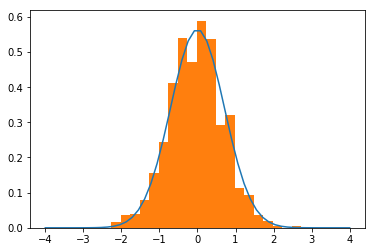

0.3984829284212386


In [34]:
%matplotlib inline
num = 1000
mu = 0
sigma = 1
pts = np.random.normal(mu, sigma / np.sqrt(2), num)
xs = np.linspace(-4 * sigma, 4 * sigma)
fs = normal(xs, mu, sigma)
plt.plot(xs, fs)
plt.hist(pts, 20, density=True)
plt.show()
print(normal(pts, mu, sigma).sum() / num)

In [35]:
knum = 1000
z = 0
ks = cbc.gaussian_dist(knum, z, waist, wavelength)[:, 0:2]
thdiv(waist,wavelength) * np.pi**0.5 / (2 * np.pi)**2 * cbc.gaussian_f(ks, z, waist, wavelength).sum() / knum

(-5.4075207852767305e-06+9.416457661845481e-06j)

# Convolution approximation

In [36]:
def gaus_dist(kxs, kys, waist, wavelength):
    thdiv = wavelength / np.pi / waist
    return np.pi**-1 * thdiv**-2 * np.exp(-(kxs**2 + kys**2) / thdiv**2)

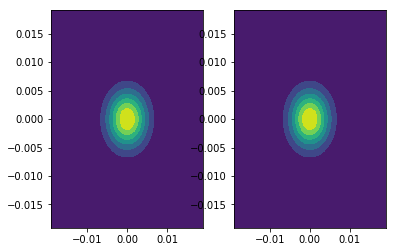

In [37]:
%matplotlib inline
knum = 100000
mus = np.zeros(2)
sigma = thdiv(waist, wavelength)
cov = [[sigma**2 / 2, 0], [0, sigma**2 / 2]]
rv = sp.stats.multivariate_normal(mean=mus, cov=cov)
_kxs = np.linspace(-4 * sigma, 4 * sigma)
kxs, kys = np.meshgrid(_kxs, _kxs)
ks = np.empty(kxs.shape + (2,))
ks[:, :, 0] = kxs; ks[:, :, 1] = kys
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.contourf(kxs, kys, gaus_dist(kxs, kys, waist, wavelength))
ax2.contourf(kxs, kys, rv.pdf(ks))

In [38]:
ks1 = np.random.multivariate_normal(mus, cov, knum)
ks2 = cbc.gaussian_dist(knum, 0, waist, wavelength)[:, 0:2]
print(
    thdiv(waist, wavelength),
    np.sqrt((ks1**2).sum(axis=-1)).sum(axis=-1) / knum * 2 / np.sqrt(np.pi),
    np.sqrt((ks2**2).sum(axis=-1)).sum(axis=-1) / knum * 2 / np.sqrt(np.pi),
sep='\n')

0.00477464829275686
0.0047757909214702346
0.004781154677600312


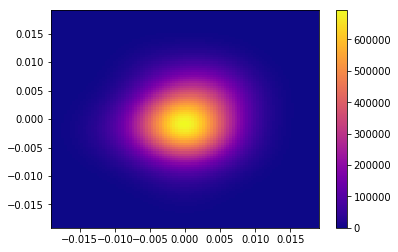

In [39]:
%matplotlib inline
knum = 100
_ks = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
kxs, kys = np.meshgrid(_ks, _ks)
ks = np.empty(kxs.shape + (2,))
ks[:,:,0] = kxs; ks[:,:,1] = kys
qs = np.random.multivariate_normal(mus, cov, knum)[np.newaxis,np.newaxis,:] - ks[:,:,np.newaxis]
fs = rv.pdf(qs).sum(axis=-1)
plt.pcolor(kxs, kys, fs, cmap=cm.plasma, vmin=0.0, vmax=fs.max())
plt.colorbar()
plt.show()

In [70]:
x, y, z = cbc.lattice(a, b, c, 2, 2, 1, lat_orig=[0,0,zR(waist, wavelength)])
x_det = np.arange((-detNx + 1) / 2.0, (detNx + 1) / 2.0) * pix_size
y_det = np.arange((-detNy + 1) / 2.0, (detNy + 1) / 2.0) * pix_size
z_det = det_dist
xdets, ydets, zdets = map(np.ravel, np.meshgrid(x_det, y_det, z_det))
XS, YS, ZS = np.subtract.outer(xdets, x), np.subtract.outer(ydets, y), np.subtract.outer(zdets, z)
RS = np.sqrt(XS**2 + YS**2 + ZS**2)

In [5]:
%matplotlib inline
x, y, z = cbc.lattice(a, b, c, Nx, Ny, Nz, lat_orig=[0,0,zR(waist, wavelength)])
asf_coeffs = cbc.asf_coeffs()
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(x, y, z, waist, wavelength)

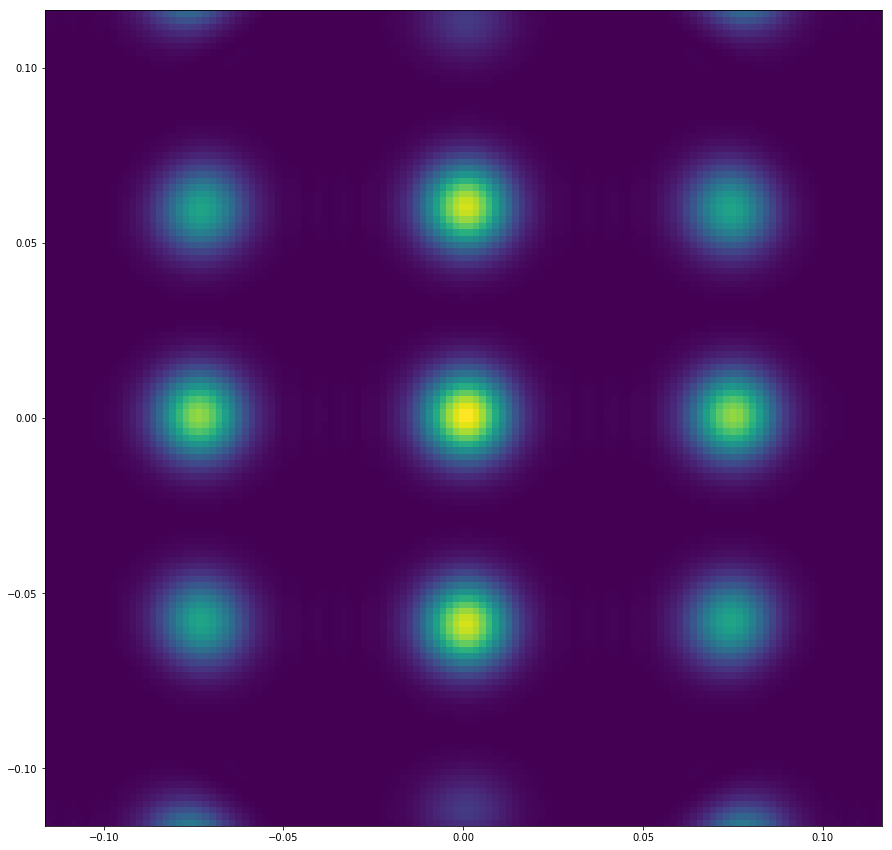

In [7]:
us = cbc.gaussian(x, y, z, waist, wavelength)
qabs = cbc.utils.q_abs(kouts, kins) / 2.0 / wavelength / 1e7
asfs = cbc.asf_vals(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, x, y, z, wavelength)
res = (asfs * us * phs).sum(axis=-1).reshape(kxs.shape)
ints = np.abs(res)
f, ax = plt.subplots(figsize=(15, 15))
ax.pcolor(kxs, kys, ints, cmap=cm.viridis, vmin=ints.min(), vmax=ints.max())
plt.show()

In [ ]:
knum = 1000
%time kjs = cbc.gaussian_dist(knum, z[0], waist, wavelength)
%time kjs = cbc.kout_parax(kjs[:,0], kjs[:,1])
%time qabs = cbc.utils.q_abs(kouts, kjs) / 2.0 / wavelength / 1e7
%time asfs = cbc.asf_vals(qabs, asf_coeffs)
%time phs = cbc.utils.phase_conv(kouts, kjs, x, y, z, wavelength)
%time res = phs.sum(axis=-2) * asfs
print(asfs.shape, phs.shape, res.shape)

CPU times: user 631 µs, sys: 123 µs, total: 754 µs
Wall time: 586 µs
CPU times: user 297 µs, sys: 201 µs, total: 498 µs
Wall time: 391 µs
CPU times: user 203 ms, sys: 84.2 ms, total: 287 ms
Wall time: 285 ms
CPU times: user 797 ms, sys: 42.9 ms, total: 840 ms
Wall time: 838 ms
CPU times: user 1min 19s, sys: 16.8 s, total: 1min 36s
Wall time: 1min 55s


In [ ]:
pts = np.vstack((x,y,z))
phis = np.exp(-2j * np.pi / wavelength * np.einsum('ij,ji->i', kins, pts))
ints2 = np.abs(res.sum(axis=-1)).reshape(kxs.shape) / knum
f, ax = plt.subplots(figsize=(15, 15))
ax.pcolor(kxs, kys, ints2, cmap=cm.viridis, vmin=ints2.min(), vmax=ints2.max())
plt.show()

# Diffraction simulation based on Henry's equations

In [3]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
kxs, kys = cbc.kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength)
print(kouts.shape, kins.shape)

(262144, 3) (1600, 3)


In [4]:
%time qs = np.subtract(kouts[:, np.newaxis], kins)
%time qs2 = cbc.utils.q_abs(kouts, kins)
print(qs.shape, qs2.shape)

CPU times: user 8.14 s, sys: 2.84 s, total: 11 s
Wall time: 11 s
CPU times: user 2.25 s, sys: 1.01 s, total: 3.26 s
Wall time: 3.25 s
(262144, 1600, 3) (262144, 1600)


In [7]:
asf_coeffs = cbc.asf_coeffs()
%time asfs = cbc.asf_vals(qs2, asf_coeffs)
print(asfs.shape)

CPU times: user 20.3 s, sys: 2.33 s, total: 22.6 s
Wall time: 22.6 s
(262144, 1600)


In [5]:
%time phs = np.exp(2j * np.pi / wavelength * np.dot(kouts, np.vstack((xs, ys, zs))))
%time phs2 = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
print(phs.shape, phs2.shape)

CPU times: user 16.4 s, sys: 8.45 s, total: 24.9 s
Wall time: 28.2 s
CPU times: user 8.3 s, sys: 2.07 s, total: 10.4 s
Wall time: 10.3 s
(262144, 1600) (262144, 1600)


In [14]:
%time res = (asfs * phs * us).sum(axis=-1)

CPU times: user 8.09 s, sys: 12.8 s, total: 20.9 s
Wall time: 24.2 s


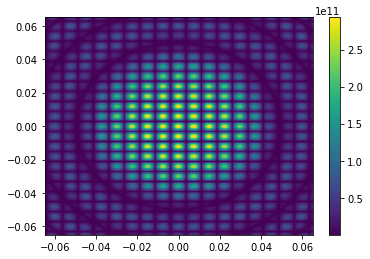

In [24]:
%matplotlib inline
res = res.reshape(kxs.shape)
ints = np.abs(res)
plt.pcolor(kxs, kys, ints, cmap=cm.viridis, vmin=ints.min(), vmax=ints.max())
plt.colorbar()
plt.show()